<a href="https://colab.research.google.com/gist/Burntt/f26e5414205542207949aeb9e9cc1ddb/demo_purgedkfoldcv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Combinatorial Purged Cross-Validation method: indexing example on crypto

*By Berend Gort*

www.medium.com/@CoderBurnt

www.linkedin.com/in/berendgort/

www.twitter.com/CoderBurnt




### Packages

In [1]:
# Install required packages

%cd /
!git clone https://github.com/AI4Finance-Foundation/FinRL-Meta
%cd /FinRL-Meta/
!pip install git+https://github.com/AI4Finance-LLC/ElegantRL.git
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git
!pip install gputil
!pip install trading_calendars
!pip install fracdiff
!pip install timeseriescv

#install TA-lib (technical analysis)
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 
!tar xvzf ta-lib-0.4.0-src.tar.gz
import os
os.chdir('ta-lib') 
!./configure --prefix=/usr
!make 
!make install
os.chdir('../')
!pip install TA-Lib
!pip install python-binance

### Imports

In [4]:
# Other imports

import scipy as sp
import math
import pandas as pd
import requests
import json
import matplotlib.dates as mdates
import numpy as np
import pickle
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools as itt
import numbers
import datetime


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns

from datetime import datetime, timedelta
#from talib.abstract import *
from binance.client import Client
from pandas.testing import assert_frame_equal
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler 
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from IPython.display import display, HTML

from itertools import combinations
from abc import abstractmethod
from typing import Iterable, Tuple, List

#from google.colab import files

In [7]:
# Plot settings

SCALE_FACTOR = 1

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [5 * SCALE_FACTOR, 2 * SCALE_FACTOR]
plt.rcParams['figure.dpi'] = 300 * SCALE_FACTOR
plt.rcParams['font.size'] = 5 * SCALE_FACTOR
plt.rcParams['axes.labelsize'] = 5 * SCALE_FACTOR
plt.rcParams['axes.titlesize'] = 6 * SCALE_FACTOR
plt.rcParams['xtick.labelsize'] = 4 * SCALE_FACTOR
plt.rcParams['ytick.labelsize'] = 4 * SCALE_FACTOR
plt.rcParams['font.family'] = 'serif'

## This requires Binance API keys

Video of how to get them easily:

https://www.youtube.com/watch?v=qg-oboAY8rM

In [8]:
# Set your Binance data API keys!


API_KEY_Binance = "qJHiV64YMnIAxA1nQFJOqJf8I9ZHaSfex44EMwLARiWHDGarV9vnvGRJ6na3K6Dp"

API_SECRET_Binance = "HS3c4TjhLEmMA4U7vGPS6poADyOX32V57jfkqwKOL6cwSz3Ikld6YHxQXQDO51t8"

In [9]:
def get_features_for_each_coin(tic_df):
  tic_df['rsi'] = RSI(tic_df['close'], timeperiod=14)
  tic_df['macd'], tic_df['macd_signal'], tic_df['macd_hist'] = MACD(tic_df['close'], fastperiod=12,
                                                                    slowperiod=26, signalperiod=9)
  tic_df['cci'] = CCI(tic_df['high'], tic_df['low'], tic_df['close'], timeperiod=14)
  tic_df['dx'] = DX(tic_df['high'], tic_df['low'], tic_df['close'], timeperiod=14)
  return tic_df

## Get data 

In [10]:
class BinanceProcessor():
    def __init__(self, api_key_binance, api_secret_binance):
        self.binance_api_key = api_key_binance  # Enter your own API-key here
        self.binance_api_secret = api_secret_binance  # Enter your own API-secret here
        self.binance_client = Client(api_key=api_key_binance, api_secret=api_secret_binance)

    def run(self, ticker_list, start_date, end_date, time_interval, technical_indicator_list, if_vix):
        data = self.download_data(ticker_list, start_date, end_date, time_interval)
        data = self.clean_data(data)
        data = self.add_technical_indicator(data, technical_indicator_list)
        data.index = data['time']

        if if_vix:
            data = self.add_vix(data)

        price_array, tech_array, turbulence_array, time_array = self.df_to_array(data, if_vix)

        tech_nan_positions = np.isnan(tech_array)
        tech_array[tech_nan_positions] = 0

        return data

    # main functions
    def download_data(self, ticker_list, start_date, end_date,
                      time_interval):

        self.start_time = start_date
        self.end_time = end_date
        self.interval = time_interval
        self.ticker_list = ticker_list

        final_df = pd.DataFrame()
        for i in ticker_list:
            hist_data = self.get_binance_bars(self.start_time, self.end_time, self.interval, symbol=i)
            df = hist_data.iloc[:-1]
            df = df.dropna()
            df['tic'] = i
            final_df = final_df.append(df)

        return final_df

    def clean_data(self, df):
        df = df.dropna()

        return df

    def add_technical_indicator(self, df, tech_indicator_list):
        # print('Adding self-defined technical indicators is NOT supported yet.')
        # print('Use default: MACD, RSI, CCI, DX.')
        self.tech_indicator_list = ['open', 'high', 'low', 'close', 'volume',
                                    'macd', 'macd_signal', 'macd_hist',
                                    'rsi', 'cci', 'dx']

        final_df = pd.DataFrame()
        for i in df.tic.unique():

            # use massive function in previous cell
            coin_df = df[df.tic == i].copy()
            coin_df = get_features_for_each_coin(coin_df)

            # Append constructed tic_df
            final_df = final_df.append(coin_df)
        return final_df

    def add_turbulence(self, df):
        print('Turbulence not supported yet. Return original DataFrame.')

        return df

    def add_vix(self, df):
        print('VIX is not applicable for cryptocurrencies. Return original DataFrame')

        return df

    def df_to_array(self, df, if_vix):
        unique_ticker = df.tic.unique()
        if_first_time = True
        for tic in unique_ticker:
            if if_first_time:
                price_array = df[df.tic == tic][['close']].values
                tech_array = df[df.tic == tic][self.tech_indicator_list].values
                if_first_time = False
            else:
                price_array = np.hstack([price_array, df[df.tic == tic][['close']].values])
                tech_array = np.hstack([tech_array, df[df.tic == tic][self.tech_indicator_list].values])

            time_array = df[df.tic == self.ticker_list[0]]['time'].values

        assert price_array.shape[0] == tech_array.shape[0]

        return price_array, tech_array, np.array([]), time_array# 

    # helper functions
    def stringify_dates(self, date: datetime):
        return str(int(date.timestamp() * 1000))

    def get_binance_bars(self, start_date, end_date, kline_size, symbol):
        data_df = pd.DataFrame()
        klines = self.binance_client.get_historical_klines(symbol, kline_size, start_date, end_date)
        data = pd.DataFrame(klines,
                            columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av',
                                     'trades', 'tb_base_av', 'tb_quote_av', 'ignore'])
        data = data.drop(labels=['close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'], axis=1)
        if len(data_df) > 0:
            temp_df = pd.DataFrame(data)
            data_df = data_df.append(temp_df)
        else:
            data_df = data

        data_df = data_df.apply(pd.to_numeric, errors='coerce')
        data_df['time'] = [datetime.fromtimestamp(x / 1000.0) for x in data_df.timestamp]
        data.drop(labels=["timestamp"], axis=1)
        data_df.index = [x for x in range(len(data_df))]

        return data_df


## Set constants

In [11]:
# Set constants:

ticker_list = ['BTCUSDT'
              ]


time_interval = '1d'

# Care format
start_date = '2015-01-01 00:00:00'
end_date = '2020-01-01 00:00:00'


technical_indicator_list = ['open',
                             'high',
                             'low',
                             'close',
                             'volume',
                             'macd',
                             'macd_signal',
                             'macd_hist',
                             'rsi',
                             'cci',
                             'dx'
                             ]

if_vix = False

In [12]:
# Process data using unified data processor

DP = BinanceProcessor(API_KEY_Binance, API_SECRET_Binance)
data_ohlcv = DP.run(ticker_list,
                    start_date,
                    end_date,
                    time_interval,
                    technical_indicator_list,
                    if_vix)

BinanceAPIException: APIError(code=0): Service unavailable from a restricted location according to 'b. Eligibility' in https://www.binance.com/en/terms. Please contact customer service if you believe you received this message in error.

In [9]:
# Drop unecessary columns

if 'timestamp' in data_ohlcv:
  data_ohlcv.drop('timestamp', inplace=True, axis=1)

if 'time' in data_ohlcv:
  data_ohlcv.drop('time', inplace=True, axis=1)

data_ohlcv.head(3)

,open,high,low,close,volume,tic,rsi,macd,macd_signal,macd_hist,cci,dx
time,,,,,,,,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,BTCUSDT,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,BTCUSDT,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,BTCUSDT,NaN,NaN,NaN,NaN,NaN,NaN


# Triple barrier method

I made a previous medium article about this, if you want to understand it please refer to my previous medium article.

However, it is not required to understand PurgedKFoldCV, you can skip on to the next section: PurgedKFoldCV =)

https://medium.com/coinmonks/crypto-feature-importance-for-deep-reinforcement-learning-38416616c2a36-8416616c2a36


In [10]:
# IMPORTANT: Make sure that pd.Timedelta() is according to the time_interval to get the volatility for that time interval

if time_interval == '5m':
  Delta = pd.Timedelta(minutes=5)
elif time_interval == '1h':
  Delta = pd.Timedelta(hours=1)
elif time_interval == '1d':
  Delta = pd.Timedelta(days=1)
else:
  raise ValueError('Timeframe not supported yet, please manually add!')

In [11]:
def get_vol(prices, span=100, delta=Delta):

  # 1. compute returns of the form p[t]/p[t-1] - 1
  # 1.1 find the timestamps of p[t-1] values
  df0 = prices.index.searchsorted(prices.index - delta)
  df0 = df0[df0 > 0]

  # 1.2 align timestamps of p[t-1] to timestamps of p[t]
  df0 = pd.Series(prices.index[df0-1],    
           index=prices.index[prices.shape[0]-df0.shape[0] : ])
  
  # 1.3 get values by timestamps, then compute returns
  df0 = prices.loc[df0.index] / prices.loc[df0.values].values - 1

  # 2. estimate rolling standard deviation
  df0 = df0.ewm(span=span).std()
  
  return df0

In [12]:
data_ohlcv = data_ohlcv.assign(volatility=get_vol(data_ohlcv.close)).dropna()

In [13]:
def get_barriers():

  #create a container
  barriers = pd.DataFrame(columns=['datapoints_passed', 
            'price', 'vert_barrier', \
            'top_barrier', 'bottom_barrier'], \
              index = daily_volatility.index)
  
  for datapoint, vol in daily_volatility.iteritems():

    datapoints_passed = len(daily_volatility.loc \
                  [daily_volatility.index[0] : datapoint])
    
    #set the vertical barrier 
    if (datapoints_passed + t_final < len(daily_volatility.index) \
        and t_final != 0):
        vert_barrier = daily_volatility.index[
                            datapoints_passed + t_final]
    else:
        vert_barrier = np.nan
        
    #set the top barrier
    if upper_lower_multipliers[0] > 0:
        top_barrier = prices.loc[datapoint] + prices.loc[datapoint] * \
                      upper_lower_multipliers[0] * vol
    else:
        #set it to NaNs
        top_barrier = pd.Series(index=prices.index)

    #set the bottom barrier
    if upper_lower_multipliers[1] > 0:
        bottom_barrier = prices.loc[datapoint] - prices.loc[datapoint] * \
                      upper_lower_multipliers[1] * vol
    else: 
        #set it to NaNs
        bottom_barrier = pd.Series(index=prices.index)
        
    barriers.loc[datapoint, ['datapoints_passed', 'price', 'vert_barrier','top_barrier', 'bottom_barrier']] = \
    datapoints_passed, prices.loc[datapoint], vert_barrier, top_barrier, bottom_barrier

  return barriers

In [14]:
# Set barrier parameters

daily_volatility = data_ohlcv['volatility']
t_final = 10
upper_lower_multipliers = [2, 2]
price = data_ohlcv['close']
prices = price[daily_volatility.index]

In [15]:
barriers = get_barriers()
barriers.head(5)

,datapoints_passed,price,vert_barrier,top_barrier,bottom_barrier
time,,,,,
2017-09-19,1,3910.04,2017-09-30 00:00:00,4530.750516,3289.329484
2017-09-20,2,3900.0,2017-10-01 00:00:00,4508.118671,3291.881329
2017-09-21,3,3609.99,2017-10-02 00:00:00,4171.469472,3048.510528
2017-09-22,4,3595.87,2017-10-03 00:00:00,4153.372755,3038.367245
2017-09-23,5,3780.0,2017-10-04 00:00:00,4360.233001,3199.766999


In [16]:
def get_labels():
  barriers["label_barrier"] = None
  for i in range(len(barriers.index)):
    start = barriers.index[i]
    end = barriers.vert_barrier[i]
    if pd.notna(end):

        # assign the initial and final price
        price_initial = barriers.price[start]
        price_final = barriers.price[end]

        # assign the top and bottom barriers
        top_barrier = barriers.top_barrier[i]
        bottom_barrier = barriers.bottom_barrier[i]

        #set the profit taking and stop loss conditons
        condition_pt = (barriers.price[start: end] >= \
          top_barrier).any()
        condition_sl = (barriers.price[start: end] <= \
          bottom_barrier).any()

        #assign the labels
        if condition_pt: 
            barriers['label_barrier'][i] = 2
        elif condition_sl: 
            barriers['label_barrier'][i] = 0    
        else: 
          barriers['label_barrier'][i] = 1
  return

In [17]:
# Use function to produce barriers

get_labels()
barriers

# Merge the barriers with the main dataset and drop the last t_final + 1 barriers (as they are too close to the end)

data_ohlcv = data_ohlcv.merge(barriers[['vert_barrier', 'top_barrier', 'bottom_barrier', 'label_barrier']], left_on='time', right_on='time')
data_ohlcv.drop(data_ohlcv.tail(t_final + 1).index,inplace = True)
data_ohlcv = data_ohlcv.drop(['vert_barrier', 'top_barrier', 'bottom_barrier','tic'], axis = 1)
data_ohlcv.head(5)

,open,high,low,close,volume,rsi,macd,macd_signal,macd_hist,cci,dx,volatility,label_barrier
time,,,,,,,,,,,,,
2017-09-19,4060.00,4089.97,3830.91,3910.04,902.332129,46.049881,-117.398092,-51.421239,-65.976853,-19.131593,38.032614,0.079374,1
2017-09-20,3910.04,4046.08,3820.00,3900.00,720.935076,45.861376,-114.436313,-64.024254,-50.412060,-15.986404,38.307447,0.077964,1
2017-09-21,3889.99,3910.00,3567.00,3609.99,1001.654084,40.681139,-133.946415,-78.008686,-55.937729,-63.756903,44.459188,0.077767,2
2017-09-22,3592.84,3750.00,3505.55,3595.87,838.966425,40.441621,-148.832034,-92.173355,-56.658678,-71.873305,45.871014,0.077520,2
2017-09-23,3595.88,3817.19,3542.91,3780.00,752.792791,44.990039,-144.110031,-102.560690,-41.549340,-35.179194,41.631687,0.076750,2


# Combinatorial PurgedKFoldCV

In [31]:
class BaseTimeSeriesCrossValidator:
    """
    Abstract class for time series cross-validation.
    Time series cross-validation requires each sample has a prediction time pred_time, at which the features are used to
    predict the response, and an evaluation time eval_time, at which the response is known and the error can be
    computed. Importantly, it means that unlike in standard sklearn cross-validation, the samples X, response y,
    pred_times and eval_times must all be pandas dataframe/series having the same index. It is also assumed that the
    samples are time-ordered with respect to the prediction time (i.e. pred_times is non-decreasing).
    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.
    """
    def __init__(self, n_splits=10):
        if not isinstance(n_splits, numbers.Integral):
            raise ValueError(f"The number of folds must be of Integral type. {n_splits} of type {type(n_splits)}"
                             f" was passed.")
        n_splits = int(n_splits)
        if n_splits <= 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting n_splits = 2 "
                             f"or more, got n_splits = {n_splits}.")
        self.n_splits = n_splits
        self.pred_times = None
        self.eval_times = None
        self.indices = None

    @abstractmethod
    def split(self, X: pd.DataFrame, y: pd.Series = None,
              pred_times: pd.Series = None, eval_times: pd.Series = None):
        if not isinstance(X, pd.DataFrame) and not isinstance(X, pd.Series):
            raise ValueError('X should be a pandas DataFrame/Series.')
        if not isinstance(y, pd.Series) and y is not None:
            raise ValueError('y should be a pandas Series.')
        if not isinstance(pred_times, pd.Series):
            raise ValueError('pred_times should be a pandas Series.')
        if not isinstance(eval_times, pd.Series):
            raise ValueError('eval_times should be a pandas Series.')
        if y is not None and (X.index == y.index).sum() != len(y):
            raise ValueError('X and y must have the same index')
        if (X.index == pred_times.index).sum() != len(pred_times):
            raise ValueError('X and pred_times must have the same index')
        if (X.index == eval_times.index).sum() != len(eval_times):
            raise ValueError('X and eval_times must have the same index')

        if not pred_times.equals(pred_times.sort_values()):
            raise ValueError('pred_times should be sorted')
        if not eval_times.equals(eval_times.sort_values()):
            raise ValueError('eval_times should be sorted')

        self.pred_times = pred_times
        self.eval_times = eval_times
        self.indices = np.arange(X.shape[0])

class CombPurgedKFoldCVLocal(BaseTimeSeriesCrossValidator):
    """
    Purged and embargoed combinatorial cross-validation
    As described in Advances in financial machine learning, Marcos Lopez de Prado, 2018.
    The samples are decomposed into n_splits folds containing equal numbers of samples, without shuffling. In each cross
    validation round, n_test_splits folds are used as the test set, while the other folds are used as the train set.
    There are as many rounds as n_test_splits folds among the n_splits folds.
    Each sample should be tagged with a prediction time pred_time and an evaluation time eval_time. The split is such
    that the intervals [pred_times, eval_times] associated to samples in the train and test set do not overlap. (The
    overlapping samples are dropped.) In addition, an "embargo" period is defined, giving the minimal time between an
    evaluation time in the test set and a prediction time in the training set. This is to avoid, in the presence of
    temporal correlation, a contamination of the test set by the train set.
    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.
    n_test_splits : int, default=2
        Number of folds used in the test set. Must be at least 1.
    embargo_td : pd.Timedelta, default=0
        Embargo period (see explanations above).
    """
    def __init__(self, n_splits=10, n_test_splits=2, embargo_td=pd.Timedelta(minutes=0)):
        super().__init__(n_splits)
        if not isinstance(n_test_splits, numbers.Integral):
            raise ValueError(f"The number of test folds must be of Integral type. {n_test_splits} of type "
                             f"{type(n_test_splits)} was passed.")
        n_test_splits = int(n_test_splits)
        if n_test_splits <= 0 or n_test_splits > self.n_splits - 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                             f"n_test_splits between 1 and n_splits - 1, got n_test_splits = {n_test_splits}.")
        self.n_test_splits = n_test_splits
        if not isinstance(embargo_td, pd.Timedelta):
            raise ValueError(f"The embargo time should be of type Pandas Timedelta. {embargo_td} of type "
                             f"{type(embargo_td)} was passed.")
        if embargo_td < pd.Timedelta(minutes=0):
            raise ValueError(f"The embargo time should be positive, got embargo = {embargo_td}.")
        self.embargo_td = embargo_td

    def split(self, X: pd.DataFrame, y: pd.Series = None,
              pred_times: pd.Series = None, eval_times: pd.Series = None) -> Iterable[Tuple[np.ndarray, np.ndarray]]:
        """
        Yield the indices of the train and test sets.
        Although the samples are passed in the form of a pandas dataframe, the indices returned are position indices,
        not labels.
        Parameters
        ----------
        X : pd.DataFrame, shape (n_samples, n_features), required
            Samples. Only used to extract n_samples.
        y : pd.Series, not used, inherited from _BaseKFold
        pred_times : pd.Series, shape (n_samples,), required
            Times at which predictions are made. pred_times.index has to coincide with X.index.
        eval_times : pd.Series, shape (n_samples,), required
            Times at which the response becomes available and the error can be computed. eval_times.index has to
            coincide with X.index.
        Returnst
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.
        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.
        """
        super().split(X, y, pred_times, eval_times)

        # Fold boundaries
        fold_bounds = [(fold[0], fold[-1] + 1) for fold in np.array_split(self.indices, self.n_splits)]
        # List of all combinations of n_test_splits folds selected to become test sets
        selected_fold_bounds = list(itt.combinations(fold_bounds, self.n_test_splits))
        # In order for the first round to have its whole test set at the end of the dataset
        selected_fold_bounds.reverse()

        for fold_bound_list in selected_fold_bounds:
            # Computes the bounds of the test set, and the corresponding indices
            test_fold_bounds, test_indices = self.compute_test_set(fold_bound_list)
            # Computes the train set indices
            train_indices = self.compute_train_set(test_fold_bounds, test_indices)

            yield train_indices, test_indices

    def compute_train_set(self, test_fold_bounds: List[Tuple[int, int]], test_indices: np.ndarray) -> np.ndarray:
        """
        Compute the position indices of samples in the train set.
        Parameters
        ----------
        test_fold_bounds : List of tuples of position indices
            Each tuple records the bounds of a block of indices in the test set.
        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.
        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.
        """
        # As a first approximation, the train set is the complement of the test set
        train_indices = np.setdiff1d(self.indices, test_indices)
        # But we now have to purge and embargo
        for test_fold_start, test_fold_end in test_fold_bounds:
            # Purge
            train_indices = purge(self, train_indices, test_fold_start, test_fold_end)
            # Embargo
            train_indices = embargo(self, train_indices, test_indices, test_fold_end)
        return train_indices

    def compute_test_set(self, fold_bound_list: List[Tuple[int, int]]) -> Tuple[List[Tuple[int, int]], np.ndarray]:
        """
        Compute the indices of the samples in the test set.
        Parameterst
        ----------
        fold_bound_list: List of tuples of position indices
            Each tuple records the bounds of the folds belonging to the test set.
        Returns
        -------
        test_fold_bounds: List of tuples of position indices
            Like fold_bound_list, but witest_fold_boundsth the neighboring folds in the test set merged.
        test_indices: np.ndarray
            A numpy array containing the test indices.
        """
        test_indices = np.empty(0)
        test_fold_bounds = []
        for fold_start, fold_end in fold_bound_list:
            # Records the boundaries of the current test split
            if not test_fold_bounds or fold_start != test_fold_bounds[-1][-1]:
                test_fold_bounds.append((fold_start, fold_end))
            # If the current test split is contiguous to the previous one, simply updates the endpoint
            elif fold_start == test_fold_bounds[-1][-1]:
                test_fold_bounds[-1] = (test_fold_bounds[-1][0], fold_end)
            test_indices = np.union1d(test_indices, self.indices[fold_start:fold_end]).astype(int)
        return test_fold_bounds, test_indices


def compute_fold_bounds(cv: BaseTimeSeriesCrossValidator, split_by_time: bool) -> List[int]:
    """
    Compute a list containing the fold (left) boundaries.
    Parameters
    ----------
    cv: BaseTimeSeriesCrossValidator
        Cross-validation object for which the bounds need to be computed.
    split_by_time: bool
        If False, the folds contain an (approximately) equal number of samples. If True, the folds span identical
        time intervals.
    """
    if split_by_time:
        full_time_span = cv.pred_times.max() - cv.pred_times.min()
        fold_time_span = full_time_span / cv.n_splits
        fold_bounds_times = [cv.pred_times.iloc[0] + fold_time_span * n for n in range(cv.n_splits)]
        return cv.pred_times.searchsorted(fold_bounds_times)
    else:
        return [fold[0] for fold in np.array_split(cv.indices, cv.n_splits)]


def embargo(cv: BaseTimeSeriesCrossValidator, train_indices: np.ndarray,
            test_indices: np.ndarray, test_fold_end: int) -> np.ndarray:
    """
    Apply the embargo procedure to part of the train set.
    This amounts to dropping the train set samples whose prediction time occurs within self.embargo_dt of the test
    set sample evaluation times. This method applies the embargo only to the part of the training set immediately
    following the end of the test set determined by test_fold_end.
    Parameters
    -------mestamps of p[t-1] values
  df0 = prices.inde---
    cv: Cross-validation class
        Needs to have the attributes cv.pred_times, cv.eval_times, cv.embargo_dt and cv.indices.
    train_indices: np.ndarray
        A numpy array containing all the indices of the samples currently included in the train set.
    test_indices : np.ndarray
        A numpy array containing all the indices of the samples in the test set.
    test_fold_end : int
        Index corresponding to the end of a test set block.
    Returns
    -------
    train_indices: np.ndarray
        The same array, with the indices subject to embargo removed.
    """
    if not hasattr(cv, 'embargo_td'):
        raise ValueError("The passed cross-validation object should have a member cv.embargo_td defining the embargo"
                         "time.")
    last_test_eval_time = cv.eval_times.iloc[test_indices[test_indices <= test_fold_end]].max()
    min_train_index = len(cv.pred_times[cv.pred_times <= last_test_eval_time + cv.embargo_td])
    if min_train_index < cv.indices.shape[0]:
        allowed_indices = np.concatenate((cv.indices[:test_fold_end], cv.indices[min_train_index:]))
        train_indices = np.intersect1d(train_indices, allowed_indices)
    return train_indices


def purge(cv: BaseTimeSeriesCrossValidator, train_indices: np.ndarray,
          test_fold_start: int, test_fold_end: int) -> np.ndarray:
    """data_ohlcv
    Purge part of the train set.
    Given a left boundary index test_fold_start of the test set, this method removes from the train set all the
    samples whose evaluation time is posterior to the prediction time of the first test sample after the boundary.
    Parameters
    ----------combinatorial purged k fold
    cv: Cross-validation class
        Needs to have the attributes cv.pred_times, cv.eval_times and cv.indices.
    train_indices: np.ndarray
        A numpy array containing all the indices of the samples currently included in the train set.
    test_fold_start : int
        Index corresponding to the start of a test set block.
    test_fold_end : int
        Index corresponding to the end of the same test set block.
    Returns
    -------
    train_indices: np.ndarray
        A numpy array containing the train indices purged at test_fold_start.
    """
    time_test_fold_start = cv.pred_times.iloc[test_fold_start]
    # The train indices before the start of the test fold, purged.
    train_indices_1 = np.intersect1d(train_indices, cv.indices[cv.eval_times < time_test_fold_start])
    # The train indices after the end of the test fold.
    train_indices_2 = np.intersect1d(train_indices, cv.indices[test_fold_end:])
    return np.concatenate((train_indices_1, train_indices_2))

### The generator function for the unique paths

In [53]:
def back_test_paths_generator(t_span, n, k, prediction_times, evaluation_times, verbose=True):
    # split data into N groups, with N << T
    # this will assign each index position to a group position
    group_num = np.arange(t_span) // (t_span // n)
    group_num[group_num == n] = n-1
    
    # generate the combinations 
    test_groups = np.array(list(itt.combinations(np.arange(n), k))).reshape(-1, k)
    C_nk = len(test_groups)
    n_paths = C_nk * k // n 
    
    
    if verbose:
        print('n_sim:', C_nk)
        print('n_paths:', n_paths)
    
    # is_test is a T x C(n, k) array where each column is a logical array 
    # indicating which observation in in the test set
    is_test_group = np.full((n, C_nk), fill_value=False)
    is_test = np.full((t_span, C_nk), fill_value=False)
    
    # assign test folds for each of the C(n, k) simulations
    for k, pair in enumerate(test_groups):
        i, j = pair
        is_test_group[[i, j], k] = True
        
        # assigning the test folds
        mask = (group_num == i) | (group_num == j)
        is_test[mask, k] = True
        
    # for each path, connect the folds from different simulations to form a backtest path
    # the fold coordinates are: the fold number, and the simulation index e.g. simulation 0, fold 0 etc
    path_folds = np.full((n, n_paths), fill_value=np.nan)
    
    for i in range(n_paths):
        for j in range(n):
            s_idx = is_test_group[j, :].argmax().astype(int)
            path_folds[j, i] = s_idx
            is_test_group[j, s_idx] = False
            cv.split(X, y, pred_times=prediction_times, eval_times=evaluation_times)
    
    # finally, for each path we indicate which simulation we're building the path from and the time indices
    paths = np.full((t_span, n_paths), fill_value= np.nan)
    
    for p in range(n_paths):
        for i in range(n):
            mask = (group_num == i)
            paths[mask, p] = int(path_folds[i, p])
    # paths = paths_# .astype(int)

    return (is_test, paths, path_folds)   

### The plotting function for the Combinatorial PurgedKFold

Made this based on https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html

In [42]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, X, y, group, ax, n_paths, k, paths, lw=5):
    """Create a sample plot for indices of a cross-validation object."""

    # generate the combinations
    N = n_paths + 1
    test_groups = np.array(list(itt.combinations(np.arange(N), k))).reshape(-1, k)
    n_splits = len(test_groups)

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X, y, pred_times=prediction_times, eval_times=evaluation_times)):

        # print('fold', ii, '\n')
        # print(tr, '\n')
        # print(tt, '\n')

        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0
        indices[np.isnan(indices)] = 2

        # Visualize the results
        ax.scatter(
            [ii + 0.5] * len(indices),
            range(len(indices)),
            c=[indices],
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        [ii + 1.5] * len(X), 
        range(len(X)), 
        c=y, 
        marker="_", 
        lw=lw, 
        cmap=cmap_data
    )

    ax.scatter(
        [ii + 2.5] * len(X), 
        range(len(X)), 
        c=group, 
        marker="_", 
        lw=lw, 
        cmap=cmap_data
    )

    # Formatting
    xlabelz = list(range(n_splits, 0 , -1))
    xlabelz = ['S' + str(x) for x in xlabelz]
    xticklabels = xlabelz + ["class", "group"]

    ax.set(
        xticks=np.arange(n_splits + 2) + 0.45,
        xticklabels=xticklabels,
        ylabel="Sample index",
        xlabel="CV iteration",
        xlim=[n_splits + 2.2, -0.2],
        ylim=[0, X.shape[0]],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=5)
    ax.xaxis.tick_top()

    return ax

### Just setting the constants + timeseriescv installation

In [43]:
data = data_ohlcv

data_index = data.index

# Train data
X = data.drop(['label_barrier'], axis = 1)
X.drop(X.tail(t_final).index,inplace = True)

# Test data
y = data[['label_barrier']]
y.reindex(data_index)
y = y[:-t_final]
y = y.squeeze()

# prediction and evalution times
t1_ = data.index

# recall that we are holding our position for 10 days
# normally t1 is important is there events such as stop losses, or take profit events
# Recall t_final from before! This is the maximum of a box!!

# prediction time is moment of observationxticklabels
prediction_times = pd.Series(t1_[:-t_final], index = X.index)

# evaluation time is moment of evaluation event
evaluation_times = pd.Series(t1_[t_final:], index = X.index)

n_sim: 15
n_paths: 5


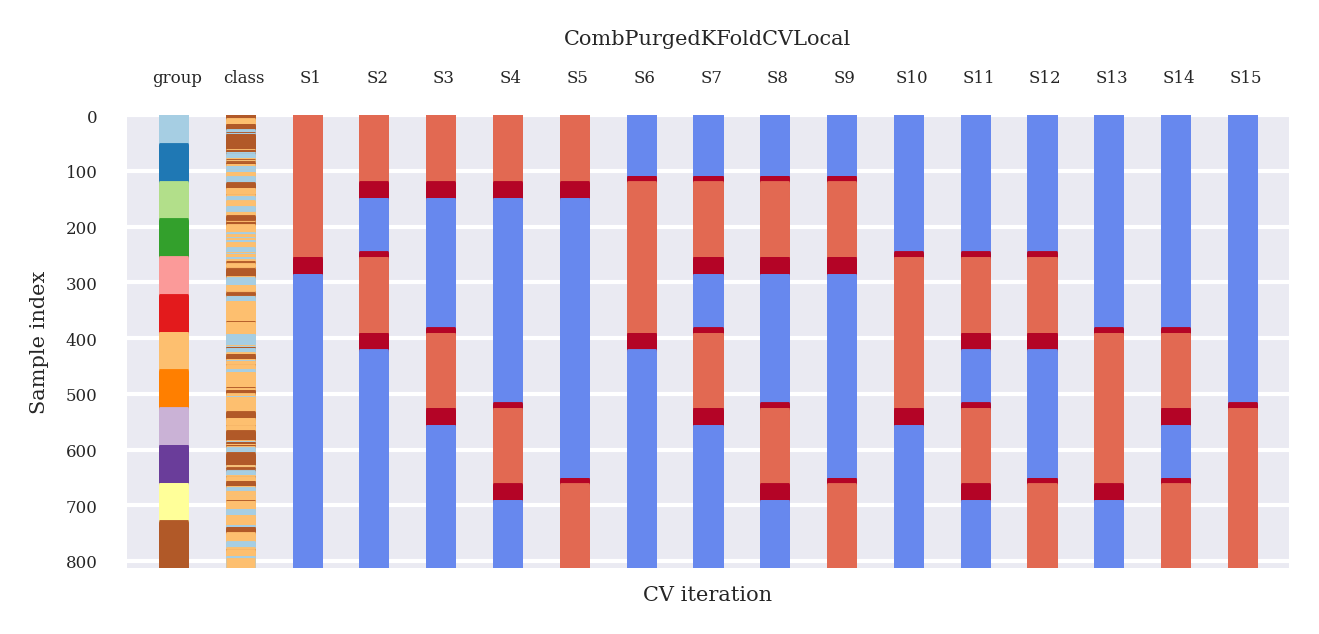

In [45]:
num_paths = 5
k = 2
N = num_paths + 1
embargo_td = Delta * t_final * 2
cv = CombPurgedKFoldCVLocal(n_splits=N, n_test_splits=k, embargo_td=embargo_td)

# Compute backtest paths
_, paths, _= back_test_paths_generator(X.shape[0], N, k, prediction_times, evaluation_times)

# Plot PurgedKFold split
groups = list(range(X.shape[0]))
fig, ax = plt.subplots()
plot_cv_indices(cv, X, y, groups, ax, num_paths, k, paths)
plt.gca().invert_yaxis()

# Paths example

In [54]:
def back_test_paths_generator(t_span, n, k, prediction_times, evaluation_times, verbose=True):
    # split data into N groups, with N << T
    # this will assign each index position to a group position
    group_num = np.arange(t_span) // (t_span // n)
    group_num[group_num == n] = n-1
    
    # generate the combinations 
    test_groups = np.array(list(itt.combinations(np.arange(n), k))).reshape(-1, k)
    C_nk = len(test_groups)
    n_paths = C_nk * k // n 
    
    print(n_paths)
    
    if verbose:
        print('n_sim:', C_nk)
        print('n_paths:', n_paths)
    
    # is_test is a T x C(n, k) array where each column is a logical array 
    # indicating which observation in in the test set
    is_test_group = np.full((n, C_nk), fill_value=False)
    is_test = np.full((t_span, C_nk), fill_value=False)
    
    # assign test folds for each of the C(n, k) simulations
    for k, pair in enumerate(test_groups):
        i, j = pair
        is_test_group[[i, j], k] = True
        
        # assigning the test folds
        mask = (group_num == i) | (group_num == j)
        is_test[mask, k] = True
        
    # for each path, connect the folds from different simulations to form a backtest path
    # the fold coordinates are: the fold number, and the simulation index e.g. simulation 0, fold 0 etc
    path_folds = np.full((n, n_paths), fill_value=np.nan)
    
    for i in range(n_paths):
        for j in range(n):
            s_idx = is_test_group[j, :].argmax().astype(int)
            path_folds[j, i] = s_idx
            is_test_group[j, s_idx] = False
            cv.split(X, y, pred_times=prediction_times, eval_times=evaluation_times)
    
    # finally, for each path we indicate which simulation we're building the path from and the time indices
    paths = np.full((t_span, n_paths), fill_value= np.nan)
    
    for p in range(n_paths):
        for i in range(n):
            mask = (group_num == i)
            paths[mask, p] = int(path_folds[i, p])
    # paths = paths_# .astype(int)

    return (is_test, paths, path_folds)   

In [62]:
# Compute backtest paths
_, paths, _= back_test_paths_generator(30, 6, k, prediction_times, evaluation_times)
paths + 1

5
n_sim: 15
n_paths: 5


array([[ 1.,  2.,  3.,  4.,  5.],
       [ 1.,  2.,  3.,  4.,  5.],
       [ 1.,  2.,  3.,  4.,  5.],
       [ 1.,  2.,  3.,  4.,  5.],
       [ 1.,  2.,  3.,  4.,  5.],
       [ 1.,  6.,  7.,  8.,  9.],
       [ 1.,  6.,  7.,  8.,  9.],
       [ 1.,  6.,  7.,  8.,  9.],
       [ 1.,  6.,  7.,  8.,  9.],
       [ 1.,  6.,  7.,  8.,  9.],
       [ 2.,  6., 10., 11., 12.],
       [ 2.,  6., 10., 11., 12.],
       [ 2.,  6., 10., 11., 12.],
       [ 2.,  6., 10., 11., 12.],
       [ 2.,  6., 10., 11., 12.],
       [ 3.,  7., 10., 13., 14.],
       [ 3.,  7., 10., 13., 14.],
       [ 3.,  7., 10., 13., 14.],
       [ 3.,  7., 10., 13., 14.],
       [ 3.,  7., 10., 13., 14.],
       [ 4.,  8., 11., 13., 15.],
       [ 4.,  8., 11., 13., 15.],
       [ 4.,  8., 11., 13., 15.],
       [ 4.,  8., 11., 13., 15.],
       [ 4.,  8., 11., 13., 15.],
       [ 5.,  9., 12., 14., 15.],
       [ 5.,  9., 12., 14., 15.],
       [ 5.,  9., 12., 14., 15.],
       [ 5.,  9., 12., 14., 15.],
       [ 5.,  

In [57]:
paths.shape

(20, 5)